In [1]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections.abc import Iterable
import time
import math

batchSize = 32 #Batch size of training set

In [2]:
def trainNetwork(model, loss_function, optimizer, numEpochs, dataloader, numOutputs):
    
    #Set model to training mode
    model.train()
    
    for epoch in range(numEpochs):
    
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        
        #Reset model parameters

        # Iterate over the DataLoader for training data
        for i, data in enumerate(dataloader, 0):

            # Get and prepare input

            preProcessedInputs = data[:, 0:4] #This line doesn't really do anything, delete later?
            targets = data[:, 4:(4+numOutputs)]

            #Process intensity by putting it on a log scale
            intens = data[:, 0:1]
            intens = np.log(intens)
            inputs = torch.cat((intens, data[:,1:4]), axis = 1)

            #Process targets by putting them on a log scale
            targets = np.log(targets)

            #print(type(inputs))

            #Comment the next two lines out if not using GPU
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')

            #Normalize inputs
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], numOutputs))

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            inputs = inputs
            outputs = model(inputs)

            #The following two lines are for debugging only
    #         if i % 10 == 0:
    #             print("Targets:", targets[0:2])
    #             print("Outputs:", outputs[0:2])
    #             print()
    #             print()

            # Compute loss
            loss = loss_function(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 10 == 0:
                print('Loss after mini-batch %5d: %.3f' %
                     (i + 1, current_loss / 500))
                current_loss = 0.0

    # Process is complete.
    print('Training process has finished.\n')

In [3]:
def calc_MSE_Error(target, output, index):
    result = np.square(np.subtract(np.exp(target[:, index].cpu().detach().numpy()), np.exp(output[:, index].cpu().detach().numpy())).mean())
                       
    return result

In [4]:
def calc_Avg_Percent_Error(target, output, index):
    difference = np.exp(target[:, index].cpu().detach().numpy()) - np.exp(output[:, index].cpu().detach().numpy())
    difference = np.abs(difference)
    error = np.divide(difference, np.exp(output[:, index].cpu().detach().numpy())) * 100
    
    result = error.mean()
    
    return result

In [5]:
def getModelError(model, epochList, loss_function, trainDataset, testDataset):
    mseErrorList = []
    avgErrorList = []
    mseTrainList = []
    avgTrainList = []
    timeList = []
    
    #print("Epochs to test:", epochList)
    
    
    for numEpochs in epochList:
        
        #Reset model parameters
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        print("Training with", numEpochs, "epochs.")
        
        #Define optimizer 
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        
        #Create dataloader for training set
        dataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
        
        #Start clock
        startTime = time.time()
        
        #First train the network
        trainNetwork(model, loss_function, optimizer, numEpochs, dataloader, numOutputs = 3)
        
        #End clock
        endTime = time.time()
        timeSpent = endTime - startTime #In seconds
        
        #Next test the network
        model.eval()
        
        #Create dataloader for testing set
        testDataloader = DataLoader(testDataset, batch_size=math.floor(0.1*points), shuffle=True)
        iterDataLoader = iter(testDataloader)
        testData = next(iterDataLoader)
        
        #Process the intens value so it is in a log scale
        intens = testData[:, 0:1]
        logIntens = np.log(intens)

        #Create the final tensor of inputs we will feed into the model
        inputs = torch.cat((logIntens, testData[:,1:4]), axis = 1)
        
        #Create the tensor of our actual values
        target = testData[:, 4:7]
        target = np.log(target)

        #Push our tensors to the GPU
        inputs = inputs.to('cuda')
        target = target.to('cuda')

        inputs, target = inputs.float(), target.float()
        target = target.reshape((target.shape[0], 3))

        #Get the model predictions and apply a log-scale to our actual values
        #(Model predictions already have a log-scale applied to them)
        output = model(inputs)
        target = np.log(testData[:, 4:7])
        
#         print(output)
#         print(target)
#         print('\n')
        
        
        
        #Initialize error lists
        #Index mappings:
        #0 = Max KE
        #1 = Total Energy
        #2 = Average Energy
        error = [0., 0., 0.]
        percentError = [0., 0., 0.]

        
        print("Calculate error for test")
        for index in range(3):
            error[index] = calc_MSE_Error(target, output, index)
            percentError[index] = calc_Avg_Percent_Error(target, output, index)
            
        #Append error values into our list
        mseErrorList.append(error)
        avgErrorList.append(percentError)
        timeList.append(timeSpent)
        
        #Also retrieve the testing error
        
        dataloader = DataLoader(trainDataset, batch_size=math.floor(0.1 * points), shuffle=True)
        iterDataLoader = iter(dataloader)
        trainData = next(iterDataLoader)
        
        #Process the intens value so it is in a log scale
        intens = trainData[:, 0:1]
        logIntens = np.log(intens)

        #Create the final tensor of inputs we will feed into the model
        inputs = torch.cat((logIntens, trainData[:,1:4]), axis = 1)
        
        #Create the tensor of our actual values
        target = trainData[:, 4:7]
        target = np.log(target)

        #Push our tensors to the GPU
        inputs = inputs.to('cuda')
        target = target.to('cuda')

        inputs, target = inputs.float(), target.float()
        target = target.reshape((target.shape[0], 3))

        #Get the model predictions and apply a log-scale to our actual values
        #(Model predictions already have a log-scale applied to them)
        trainOutput = model(inputs)
        trainTarget = np.log(trainData[:, 4:7])
        
#         print(output)
#         print(target)


        print("Calculate error for train")
    
        trainError = [0., 0., 0.]
        trainPercentError = [0., 0., 0.]
        
        for index in range(3):
            trainError[index] = calc_MSE_Error(trainTarget, trainOutput, index)
            trainPercentError[index] = calc_Avg_Percent_Error(trainTarget, trainOutput, index)
            
        #Append error values
        mseTrainList.append(trainError)
        avgTrainList.append(trainPercentError)
        
    return mseErrorList, avgErrorList, mseTrainList, avgTrainList, timeList

# Define our neural networks

In [6]:
class MultiRegressor3Layers(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(4)
    self.linear1 = nn.Linear(in_features=4, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.dropout = nn.Dropout()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    #self.dropout = nn.Dropout()
    self.act2 = nn.LeakyReLU()
    self.linear3 = nn.Linear(in_features=16, out_features=8)
    self.act3 = nn.LeakyReLU()
    #self.dropout = nn.Dropout()
    self.output = nn.Linear(in_features=8, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    #x = self.dropout(x)
    x = self.linear2(x)
    x = self.norm2(x)
    #x = self.dropout(x)
    x = self.act2(x)
    x = self.linear3(x)
    x = self.act3(x)
    #x = self.dropout(x)
    x = self.output(x)
    
    
    return x

In [7]:
class MultiRegressor2Layers(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(4)
    self.linear1 = nn.Linear(in_features=4, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.dropout = nn.Dropout()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    #self.dropout = nn.Dropout()
    self.act2 = nn.LeakyReLU()
    #self.dropout = nn.Dropout()
    self.output = nn.Linear(in_features=16, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    #x = self.dropout(x)
    x = self.linear2(x)
    x = self.norm2(x)
    #x = self.dropout(x)
    x = self.act2(x)
    #x = self.linear3(x)
    #x = self.act3(x)
    #x = self.dropout(x)
    x = self.output(x)
    
    
    return x

In [8]:
def splitErrorList(errorList):
    maxEnergyError = []
    totalEnergyError = []
    avgEnergyError = []

    for element in errorList:
        maxEnergyError.append(element[0])
        totalEnergyError.append(element[1])
        avgEnergyError.append(element[2])
        
    return maxEnergyError, totalEnergyError, avgEnergyError

# Read in the data

In [ ]:
numPoints = [100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 40000, 50000, 100000]

timeList = []
maxEnMSE = []
totalEnMSE = []
avgEnMSE = []
maxEnPercent = []
totalEnPercent = []
avgEnPercent = []
trainMaxMSEList = []
trainTotalMSEList = []
trainAvgMSEList = []
trainMaxPercentList = []
trainTotalPercentList = []
trainAvgPercentList = []

for points in numPoints:

    print("Processing " + str(points) + " points.")
    
    filename = 'Data_Fuchs_v_2.2_Wright_Pat_Narrow_Range_lambda_um_0.8_points_' + str(points) + '_seed_0.h5'

    h5File = h5py.File(filename, 'r+')

    #Read columns

    intens = h5File['Intensity_(W_cm2)']
    duration = h5File['Pulse_Duration_(fs)']
    thickness = h5File['Target_Thickness (um)']
    spotSize = h5File['Spot_Size_(FWHM um)']
    maxEnergy = h5File['Max_Proton_Energy_(MeV)']
    totalEnergy = h5File['Total_Proton_Energy_(MeV)']
    avgEnergy = h5File['Avg_Proton_Energy_(MeV)']


    #Convert columns into numpy arrays
    npIntens = np.fromiter(intens, float)
    npDuration = np.fromiter(duration, float)
    npThickness = np.fromiter(thickness, float)
    npSpot = np.fromiter(spotSize, float)
    npMaxEnergy = np.fromiter(maxEnergy, float)
    npTotalEnergy = np.fromiter(totalEnergy, float)
    npAvgEnergy = np.fromiter(avgEnergy, float)


    #Join all of those arrays into one big numpy array
    npFile = np.dstack((npIntens, npDuration, npThickness, npSpot, npMaxEnergy, npTotalEnergy, npAvgEnergy))

    npFile = npFile.reshape(points, 7)

    npTrain = npFile[:math.floor(.9 * points), 0:7]
    npTest = npFile[math.floor(.9*points):, 0:7]

    print(npFile.shape)

    training_dataset = h5File.create_dataset(name=None, data=npTrain)
    test_dataset = h5File.create_dataset(name=None, data=npTest)

    #Choose our loss function and optimizer

    loss_function = nn.MSELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    #List which epochs we should test

    #epochList = [1, 2, 3]
    epochList = [20]
    #epochList = [1, 5, 10]

    #Initialize neural network and dataloader
    model2Layer = MultiRegressor2Layers().to('cuda')
    
    
    model2LayerMSE, model2LayerPercentError, trainMSE, trainPercent, timeSpent = getModelError(model2Layer, epochList, loss_function, training_dataset, test_dataset)
    
    #print(model2LayerMSE) #For debugging purposes
    
    model2LayerMSE = model2LayerMSE[0]
    model2LayerPercentError = model2LayerPercentError[0]
    trainMSE = trainMSE[0]
    trainPercent = trainPercent[0]
    
#    print(model2LayerPercentError)
#     print(trainMSE)
#    print(trainPercent)
    
    maxEnergyMSE, totalEnergyMSE, avgEnergyMSE = model2LayerMSE[0], model2LayerMSE[1], model2LayerMSE[2]
    maxEnergyPercent, totalEnergyPercent, avgEnergyPercent = model2LayerPercentError[0], model2LayerPercentError[1], model2LayerPercentError[2]
    trainMaxMSE, trainTotalMSE, trainAvgMSE = trainMSE[0], trainMSE[1], trainMSE[2]
    trainMaxPercent, trainTotalPercent, trainAvgPercent = trainPercent[0], trainPercent[1], trainPercent[2]
    
    
    #Append values to list
    timeList.append(timeSpent)
    maxEnMSE.append(maxEnergyMSE)
    totalEnMSE.append(totalEnergyMSE)
    avgEnMSE.append(avgEnergyMSE)
    maxEnPercent.append(maxEnergyPercent)
    totalEnPercent.append(totalEnergyPercent)
    avgEnPercent.append(avgEnergyPercent)
    trainMaxMSEList.append(trainMaxMSE)
    trainTotalMSEList.append(trainTotalMSE)
    trainAvgMSEList.append(trainAvgMSE)
    trainMaxPercentList.append(trainMaxPercent)
    trainTotalPercentList.append(trainTotalPercent)
    trainAvgPercentList.append(trainAvgPercent)

# Now plot errors and time spent

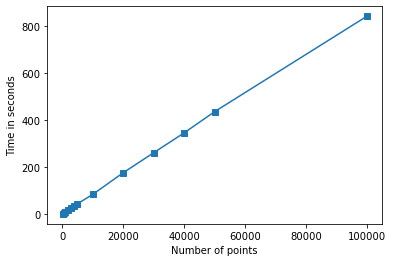

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

#Time spent plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(numPoints, timeList, marker='s')
plt.xlabel("Number of points")
plt.ylabel("Time in seconds")


#plt.legend(loc='upper left');
plt.show()

In [26]:
for point, time in zip(numPoints, timeList):
    
    minuteValue = time[0] / 60
    
    print("Number of points:", point)
    print("Time spent:", minuteValue, "minutes", '\n')

Number of points: 100
Time spent: 0.016349951426188152 minutes 

Number of points: 500
Time spent: 0.0662332812945048 minutes 

Number of points: 1000
Time spent: 0.13165001471837362 minutes 

Number of points: 2000
Time spent: 0.2971670071283976 minutes 

Number of points: 3000
Time spent: 0.4507332722345988 minutes 

Number of points: 4000
Time spent: 0.5440333008766174 minutes 

Number of points: 5000
Time spent: 0.7354166666666667 minutes 

Number of points: 10000
Time spent: 1.396066709359487 minutes 

Number of points: 20000
Time spent: 2.9307833274205524 minutes 

Number of points: 30000
Time spent: 4.34896692832311 minutes 

Number of points: 40000
Time spent: 5.7557332754135135 minutes 

Number of points: 50000
Time spent: 7.2570499340693155 minutes 

Number of points: 100000
Time spent: 14.018451070785522 minutes 



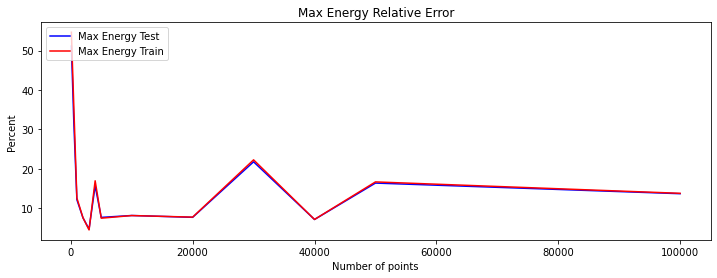

In [55]:
#Percent Error plot
fig = plt.figure(figsize = (12, 4))
#ax1 = fig.add_subplot(1,1,1)

#ax1.scatter(numPoints, maxEnPercent, s=10, c='b', marker="s", label='Max Energy')
#ax1.scatter(numPoints, totalEnPercent, s=10, c='r', marker="o", label='Total Energy')
#ax1.scatter(numPoints, avgEnPercent, s=10, c='g', marker='+', label='Average Energy')

#print(trainMaxPercent)

plt.plot(numPoints, maxEnPercent, c='b', label = 'Max Energy Test')
plt.plot(numPoints, trainMaxPercentList, c='r', label = 'Max Energy Train')

plt.legend(loc='upper left');
plt.title("Max Energy Relative Error")
plt.xlabel("Number of points")
plt.ylabel("Percent")
plt.show()

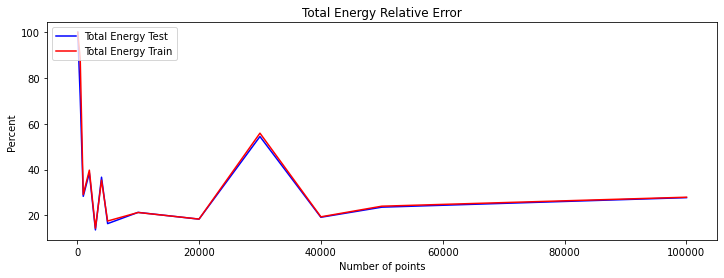

In [53]:
#Percent Error plot
fig = plt.figure(figsize = (12, 4))

plt.plot(numPoints, totalEnPercent, c='b', label = 'Total Energy Test')
plt.plot(numPoints, trainTotalPercentList, c='r', label = 'Total Energy Train')

plt.legend(loc='upper left');
plt.title("Total Energy Relative Error")
plt.xlabel("Number of points")
plt.ylabel("Percent")
plt.show()

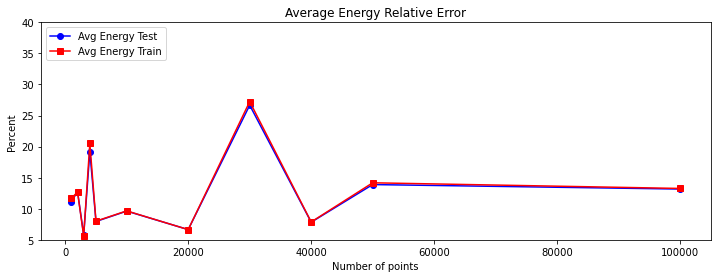

In [47]:
#Percent Error plot
fig = plt.figure(figsize = (12, 4))

plt.plot(numPoints[2:], avgEnPercent[2:], c='b', label = 'Avg Energy Test', marker='o')
plt.plot(numPoints[2:], trainAvgPercentList[2:], c='r', label = 'Avg Energy Train', marker='s')

plt.legend(loc='upper left');
plt.title("Average Energy Relative Error")
plt.ylim([5, 40])
plt.xlabel("Number of points")
plt.ylabel("Percent")
plt.show()

Text(0, 0.5, 'Average Energy Error (MeV)')

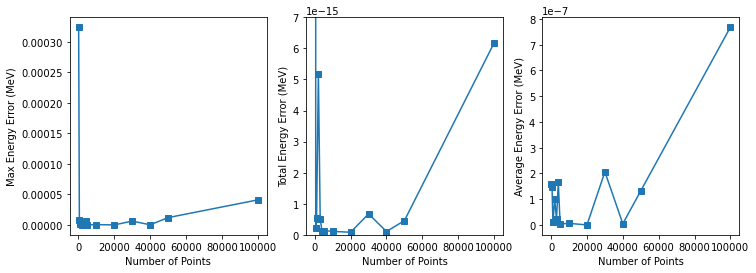

In [62]:
#MSE Error plot

fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.plot(numPoints, maxEnMSE, marker = 's')
plt.xlabel('Number of Points')
plt.ylabel('Max Energy Error (MeV)')

plt.subplot(1, 3, 2)
plt.plot(numPoints, totalEnMSE, marker = 's')
plt.ylim([0,7e-15])
plt.xlabel('Number of Points')
plt.ylabel('Total Energy Error (MeV)')

plt.subplot(1, 3, 3)
plt.plot(numPoints, avgEnMSE, marker = 's')
plt.xlabel('Number of Points')
plt.ylabel('Average Energy Error (MeV)')

# Raw data

In [50]:
#Percent error for test data

for pointAmount, maxError, totalError, avgError in zip(numPoints, maxEnPercent, totalEnPercent, avgEnPercent):
    print("Number of points:", pointAmount)
    print("Max energy percent error:", maxError)
    print("Total energy percent error:", totalError)
    print("Average energy percent error:", avgError, '\n')

Number of points: 100
Max energy percent error: 51.11900025833421
Total energy percent error: 99.98962941565023
Average energy percent error: 92.06623913889993 

Number of points: 500
Max energy percent error: 31.7130884128016
Total energy percent error: 71.70924289187744
Average energy percent error: 30.444354461976836 

Number of points: 1000
Max energy percent error: 12.225570114240474
Total energy percent error: 28.289086821938877
Average energy percent error: 11.112863087619408 

Number of points: 2000
Max energy percent error: 7.634712186955392
Total energy percent error: 38.53267480321875
Average energy percent error: 12.773827834138816 

Number of points: 3000
Max energy percent error: 4.7807257071036915
Total energy percent error: 13.610958572411532
Average energy percent error: 5.793757286592924 

Number of points: 4000
Max energy percent error: 15.72988713494614
Total energy percent error: 36.643413602412735
Average energy percent error: 19.191929489703465 

Number of points

In [52]:
#Percent error for train data

for pointAmount, maxError, totalError, avgError in zip(numPoints, trainMaxPercentList, trainTotalPercentList, trainAvgPercentList):
    print("Number of points:", pointAmount)
    print("Max energy percent error:", maxError)
    print("Total energy percent error:", totalError)
    print("Average energy percent error:", avgError, '\n')

Number of points: 100
Max energy percent error: 54.63157349309175
Total energy percent error: 99.97209152102648
Average energy percent error: 193.6955188099462 

Number of points: 500
Max energy percent error: 35.79257651007673
Total energy percent error: 88.61831979070939
Average energy percent error: 33.75493788607352 

Number of points: 1000
Max energy percent error: 12.657612007833643
Total energy percent error: 29.062842134856414
Average energy percent error: 11.678415683068431 

Number of points: 2000
Max energy percent error: 7.659335190828313
Total energy percent error: 39.72604578477168
Average energy percent error: 12.694137070706443 

Number of points: 3000
Max energy percent error: 4.565684333709083
Total energy percent error: 14.353136947386513
Average energy percent error: 5.628487545162926 

Number of points: 4000
Max energy percent error: 17.01154243382638
Total energy percent error: 35.31984559481986
Average energy percent error: 20.533979384032335 

Number of points: 

In [57]:
#MSE error for test data

for pointAmount, maxError, totalError, avgError in zip(numPoints, maxEnMSE, totalEnMSE, avgEnMSE):
    print("Number of points:", pointAmount)
    print("Max energy MSE error:", maxError)
    print("Total energy MSE error:", totalError)
    print("Average energy MSE error:", avgError, '\n')

Number of points: 100
Max energy percent error: 0.0003238279205739089
Total energy percent error: 9.258750360240647e-07
Average energy percent error: 1.6021056727181803e-07 

Number of points: 500
Max energy percent error: 8.051610646608436e-06
Total energy percent error: 2.178787062384043e-16
Average energy percent error: 1.4788485671623207e-07 

Number of points: 1000
Max energy percent error: 1.936825211442504e-06
Total energy percent error: 5.537063738765647e-16
Average energy percent error: 1.0018621934626161e-08 

Number of points: 2000
Max energy percent error: 1.7012040147478054e-07
Total energy percent error: 5.1900349613077684e-15
Average energy percent error: 9.992897154390669e-08 

Number of points: 3000
Max energy percent error: 5.19134181053216e-09
Total energy percent error: 5.087360605066954e-16
Average energy percent error: 2.1615018604044484e-08 

Number of points: 4000
Max energy percent error: 6.279372331806635e-06
Total energy percent error: 1.2482005337782794e-16
